# Reasearch Project

#### How does the FED rate effect the value of Bitcoin?

In our project we investigated if there was any relationship between the effective rate set by the Federal Reserve and the value of the cryptocurrency, Bitcoin, relative to the US dollar.

###### All widgets must be selected each time you wish to look at the results even if they are to remain the same!

###### Libraries

In [1]:
import fredapi as fa
import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import json

Our inference was performed on Bitcoin over the time period from 2016 to present but we allow the user to select from a few coins and their own time period. 

NOTE: Due to the Binance API, the maximum period that can be looked at is 1000 days.

In [2]:
coin = widgets.Dropdown(
    options=[('Bitcoin','BTC'), ('Etherium','ETH'), ('Dogecoin','DOGE'),('Tether','USDT')],
    description='Coin:',
    disabled=False,
)
display(coin)

Dropdown(description='Coin:', options=(('Bitcoin', 'BTC'), ('Etherium', 'ETH'), ('Dogecoin', 'DOGE'), ('Tether…

In [3]:
start = widgets.DatePicker(
    description='Start Date:',
    disabled=False
)
display(start)

DatePicker(value=None, description='Start Date:')

In [4]:
lim = widgets.IntText(
    description='Period:',
    min=1,
    max=1000,
    disabled=False
)

display(lim)

IntText(value=0, description='Period:')

###### Load in Data from API's

In [5]:
#Load COIN date from BINANCE
ROOT_url = "https://api.binance.com"
endpoint_klines = "api/v3/klines"
market = coin.value
tick_interval = '1d'
since = datetime.strptime(str(start.value),"%Y-%m-%d")
since = int(since.timestamp() * 1000)
limit= lim.value
    
    # construct request URL
req = "{root_url}/{endpoint}?symbol={symbol}USDT&interval={tick_interval}&limit={limit}&startTime={since}" \
     .format(root_url=ROOT_url,
             endpoint=endpoint_klines,
             symbol=market,
             tick_interval=tick_interval,
             limit=limit,
             since=since)

resp = requests.get(req)
data = resp.json()
COIN = pd.DataFrame(data)

COIN.columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'qav','num_trades','taker_base_vol','taker_quote_vol', 'ignore']
COIN['Date'] = [datetime.fromtimestamp(x/1000.0) for x in COIN.close_time] 
COIN['Date'] = [datetime.date(x) for x in COIN['Date']]
COIN = COIN.set_index('Date',drop=True) #makes the date the index for dataframe

#Load FED date from FRED API
fred = fa.Fred(api_key='e267228dfe07586b6b20cddb18e30275')
FED = pd.DataFrame(fred.get_series('DFF',str(start.value)),columns=['Rate'])
FED = FED.loc[COIN.index] #Takes only dates where they both have values

###### Plot the data

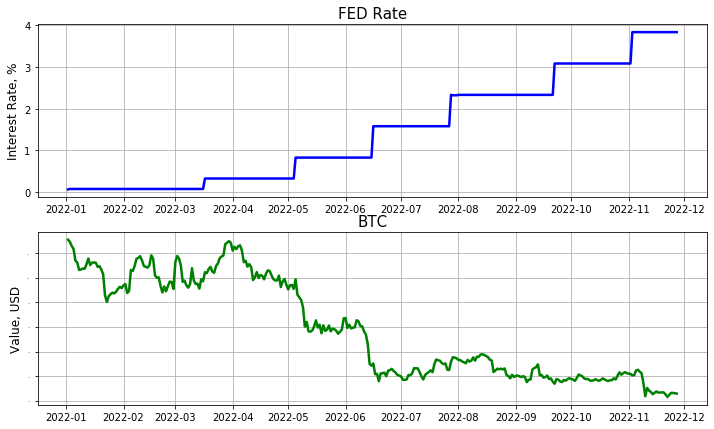

In [6]:
plt.figure(figsize=(12, 7))

plt.subplot(2, 1, 1)
plt.plot(FED.Rate,linewidth=2.5,color='b')
plt.ylabel('Interest Rate, %',fontsize=12)
plt.grid(True)
plt.title('FED Rate',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2, 1, 2)
plt.plot(pd.to_numeric(COIN.close),linewidth=2.5,color='g')
plt.ylabel('Value, USD',fontsize=12)
plt.grid(True)
plt.title(str(coin.value),fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=1)

plt.show()

We will check the following:
- Correlation between FED rate and coin price.
- Correlation between FED rate and MA of the coin price.
- Correlation between FED rate changes and coin variance

###### Coin Value

In [7]:
rho = np.corrcoef(pd.to_numeric(COIN.close),FED.Rate)[0,1]
print("The correlation coefficient is: "+str(round(rho,4)))

if abs(rho) < 0.2:
    print('There is no correlation')
else:
    if rho < 0: 
        corr = "negative"
    else:
        corr = "positive"
    if abs(rho) < 0.5: 
        rel = "weak"
    elif abs(rho) < 0.7: 
        rel = "medium"
    else:
        rel = "strong"
    print("There is " + rel + " " + corr + " correlation")
    

The correlation coefficient is: -0.8914
There is strong negative correlation


###### Moving Averages

Now we can check the MA, common periods for the moving average are 5,10,20,50,100 days.

In [453]:
days = widgets.Dropdown(
    options=[('5 Days',5), ('10 Days',10), ('20 Days',20), ('50 Days',50), ('100 Days',100)],
    description='Period',
    disabled=False,
)
display(days)

Dropdown(description='Period', options=(('5 Days', 5), ('10 Days', 10), ('20 Days', 20), ('50 Days', 50), ('10…

In [472]:
period = days.value

MA = [0]*(len(COIN))

for ind in range(period-1,len(COIN)):
    start = ind - period + 1
    end = ind
        
    MA[ind] = np.mean(pd.to_numeric(COIN['close']).iloc[start:end])
    
MA_data = pd.DataFrame(MA,columns = [str(period) + 'MA'],index = COIN.index)

#Remove zero values at start
dates = MA_data.index[period:]
MA_data = MA_data.loc[dates]

FED_tmp = FED.loc[dates]

Plot the MA vs FED rate

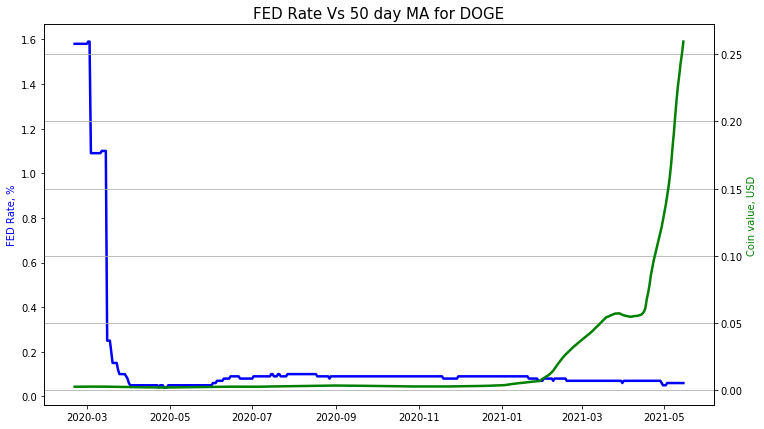

In [473]:
fig, ax1 = plt.subplots(figsize=(12, 7))
ax2 = ax1.twinx()
           
ax1.plot(FED_tmp.Rate,linewidth=2.5,color='b')
ax2.plot(MA_data,linewidth=2.5,color='g')
ax1.set_ylabel('FED Rate, %', color='b',fontsize=10)
ax2.set_ylabel('Coin value, USD', color='g',fontsize=10)

plt.grid(True)
plt.title('FED Rate Vs '+str(period) +" day MA for "+str(coin.value),fontsize=15)
plt.xticks(fontsize=10)

plt.show()

In [474]:
rho = np.corrcoef(MA_data.iloc[:,0],FED_tmp.Rate)[0,1]
print("The correlation coefficient is: "+str(round(rho,4)))

if abs(rho) < 0.2:
    print('There is no correlation')
else:
    if rho < 0: 
        corr = "negative"
    else:
        corr = "positive"
    if abs(rho) < 0.5: 
        rel = "weak"
    elif abs(rho) < 0.7: 
        rel = "medium"
    else:
        rel = "strong"
    print("There is " + rel + " " + corr + " correlation")
    

The correlation coefficient is: -0.113
There is no correlation


###### Coin Variance and Rate changes

FED rate changes:

In [481]:
CHG_rate = abs(FED.diff(1))

Rolling variance for coin price:

In [482]:
days = widgets.Dropdown(
    options=[('20 Days',20), ('50 Days',50), ('100 Days',100)],
    description='Period',
    disabled=False,
)
display(days)

Dropdown(description='Period', options=(('20 Days', 20), ('50 Days', 50), ('100 Days', 100)), value=20)

In [483]:
period = days.value

VOL = [0]*(len(COIN))

for ind in range(period-1,len(COIN)):
    start = ind - period + 1
    end = ind
        
    VOL[ind] = np.var(pd.to_numeric(COIN['close']).iloc[start:end])
    
VOL_data = pd.DataFrame(VOL,columns = [str(period) + '-day VOL'],index = COIN.index)

#Remove zero values at start
dates = VOL_data.index[period:]
VOL_data = VOL_data.loc[dates]

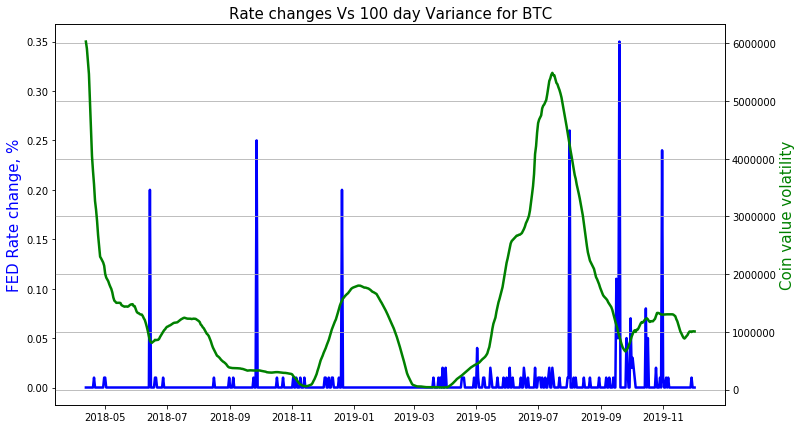

In [484]:
fig, ax1 = plt.subplots(figsize=(12, 7))
ax2 = ax1.twinx()
           
ax1.plot(CHG_rate.loc[dates,'Rate'],linewidth=2.5,color='b')
ax2.plot(VOL_data,linewidth=2.5,color='g')
ax1.set_ylabel('FED Rate change, %', color='b',fontsize=15)
ax2.set_ylabel('Coin value volatility', color='g',fontsize=15)

plt.grid(True)
plt.title('Rate changes Vs '+str(period) +" day Variance for "+str(coin.value),fontsize=15)
plt.xticks(fontsize=10)

plt.show()

In [485]:
rho = np.corrcoef(VOL_data.iloc[:,0],CHG_rate.loc[dates,'Rate'])[0,1]
print("The correlation coefficient is: "+str(round(rho,4)))

if abs(rho) < 0.2:
    print('There is no correlation')
else:
    if rho < 0: 
        corr = "negative"
    else:
        corr = "positive"
    if abs(rho) < 0.5: 
        rel = "weak"
    elif abs(rho) < 0.7: 
        rel = "medium"
    else:
        rel = "strong"
    print("There is " + rel + " " + corr + " correlation")
    

The correlation coefficient is: 0.0215
There is no correlation
